# Identify Object Positions in Images - YOLO vs VLM 

In [1]:
# Import YOLO and load a pre-trained model
from ultralytics import YOLO



# Load the YOLOv8 pre-trained model
model = YOLO('yolov8n.pt')  # nano model for quick inference


# Get the class ID for the target object
target_object_name = "cup"  # Replace with your target object name
class_names = model.names
target_class_id = next((class_id for class_id, name in class_names.items() if name == target_object_name), None)



if target_class_id is not None:
    # Perform inference
    results = model('images/table_scene.jpeg', save = True)  # Replace with your image path

    # Filter bounding boxes for the target object
    detections = results[0].boxes
    specific_boxes = [
        box.xyxy[0].tolist()
        for box in detections
        if int(box.cls[0]) == target_class_id
    ]

    print(f"Bounding boxes for '{target_object_name}': {specific_boxes}")
else:
    print(f"Object name '{target_object_name}' not found in the model's class names.")


image 1/1 /workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg: 640x640 1 cup, 2 potted plants, 2 dining tables, 4 books, 3 vases, 1496.7ms
Speed: 22.0ms preprocess, 1496.7ms inference, 144.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
Bounding boxes for 'cup': [[615.28662109375, 553.3635864257812, 845.9586181640625, 780.4920654296875]]


### Utils 


In [2]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))





# VLM (1): OPEN-AI

In [3]:
from openai import OpenAI
import os
import base64


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

openAIclient = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
img = "images/table_scene.jpeg"


In [4]:
#basic call to gpt4 with prompt and image

completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Detect if there is a cup in the image and reutrn its coordinates as a list in the format [ymin,xmin, ymax, xmax]. Just output the list."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                    }
                },
            ],
        }
    ],
)


# Wrap the text to a specified width

response = str(completion.choices[0].message.content)



In [5]:
response

'[368, 516, 447, 583]'

(1024, 1024)


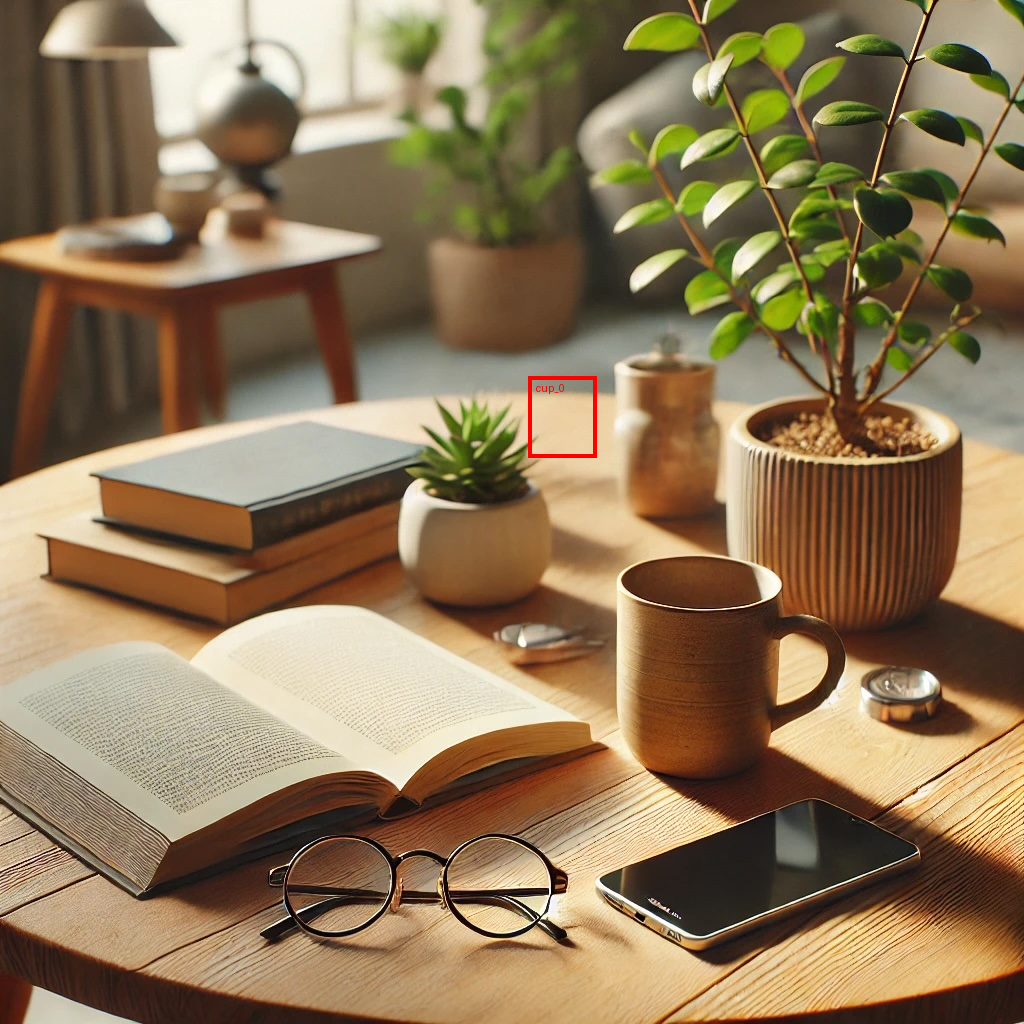

In [6]:
boxes= parse_list_boxes(response)
boxes = {f'cup_{i}': x for i, x in enumerate(boxes)}
plot_bounding_boxes(Image.open(img), noun_phrases_and_positions=list(boxes.items()))

# VLM (2): GEMINI


In [7]:
%matplotlib inline
import os
import google.generativeai as genai
from PIL import Image
import requests
import io

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a cup in the image and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[543, 596, 756, 821]


(1024, 1024)


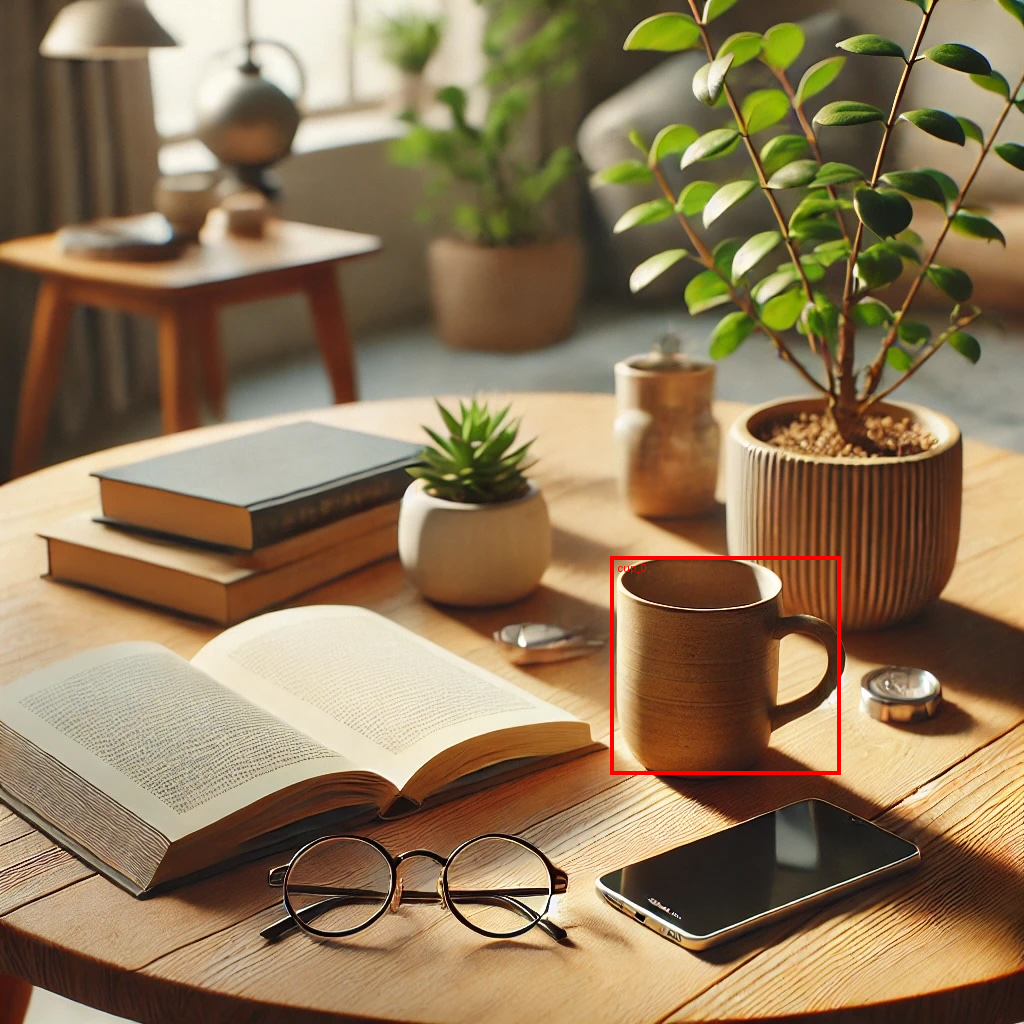

In [9]:
boxes= parse_list_boxes(response.text)
boxes = {f'cup_{i}': x for i, x in enumerate(boxes)}
plot_bounding_boxes(im, noun_phrases_and_positions=list(boxes.items()))